<a href="https://colab.research.google.com/github/Venu2791/Deep-Vision/blob/master/Assignment%209/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment 9

**Problem Statement:**

*   Implement GradCAM for CIFAR 10. Take the optimized code from assignement 6A and integrate GradCAM to the final layer.
*   Add cut out to the same version of the code and repeat the previous step.

**Objective:**


*   Implement GradCAM with the model.
*   Understand how cutout encourages the model to take more minor features into consideration when making decisions, rather than relying on the presence of a few major features.





In [1]:
from keras import backend as K
import time
from keras.preprocessing import image
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(100)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10
!pip install -q utils 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


Using TensorFlow backend.


##Loading dataset

Cifar10 has 10 different classes. Train data : 50000 and Test data : 10000.
Image Resolution :32X32



In [0]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Sample Plot for CIFAR10:**
1. Create a list for classes in CIFAR10 dataset.
2. Create the subplot figure.
2. Iterate over each class and Pick a random image for each class from the train dataset.
3. Subplot all the classes of CIFAR10 with the appropriate label.

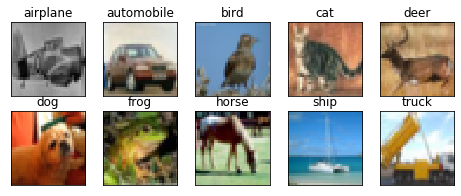

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

The below code is to plot the comparison of loss and accuracy betweeen train and test dataset taking model.fit as argument.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##Test Accuracy:
With the trained model, we do the predictions for the test dataset using predict function. We then compute the accuracy.

Accuracy= # of correct predictions/number of samples.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##Preprocessing data

1. Convert the image matrices to float and standardize (Dividing by 255) both train and test data. 
2. One-hot coding the train and test labels.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Model Architecture:**

32X32X3    |  3X3X3X32         | 32X32X32    GRF-3  </br>
32X32X32   |  3X3X32X64        | 32X32X64    GRF-5  </br>
32X32X64   |  3X3X64X128       | 32X32X128   GRF-7</br>
32X32X128  | maxpooling(2,2)   | 16X16X128   GRF-8</br>
16X16X128  |  1X1X128X32       | 16X16X32    GRF-8</br> 
16X16X32   |  3X3X32X64        | 16X16X64    GRF-12</br>
16X16X64   |  3X3X64X128       | 16X16X128   GRF-16</br>
16X16X128  | maxpooling(2,2)   | 8X8X128     GRF-18</br>
8X8X128    |  1X1X128X32       | 8X8X32      GRF-18</br>
8X8X32     |  3X3X32X64        | 8X8X64      GRF-26</br>
8X8X64     |  8X8X64X10        | 8X8X10      GRF-34</br>
8X8X128    |  7X7X10X10        | 2X2X10      GRF-34</br>
2X2X10     |  GlobalAvgPooling | 1X1X10

In [0]:
# Define the model
#Convolution block
def get_model():

 model = Sequential()
 model.add(Convolution2D(32, 3, activation='relu', border_mode='same', input_shape=(32, 32, 3))) #GRF - 3
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(64, 3,3, border_mode='same',activation='relu'))#GRF -5 
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu')) #GRF -7
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(MaxPooling2D(pool_size=(2, 2)))#GRF -8
 model.add(Convolution2D(32, 1, activation='relu')) #GRF -8
 model.add(Dropout(0.1))

 model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu'))#GRF -12
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(128, 3, 3, activation='relu'))#GRF -16
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(MaxPooling2D(pool_size=(2, 2)))#GRF -18
 model.add(Convolution2D(32, 1, activation='relu')) #GRF -18
 model.add(Dropout(0.1))

 model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))#GRF -26
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu'))#GRF -26
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(10, 1, 1, border_mode='same',activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(0.1))

 model.add(Convolution2D(10, 7, 7,border_mode='same'))#GRF-34
#model.add(Convolution2D(10, 1, 1, border_mode='same',activation='relu'))

 model.add(GlobalAveragePooling2D())
 model.add(Activation('softmax'))
 return model;

In [8]:
#model.add(Flatten())
model=get_model()
model.summary()


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, activation="relu", input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update you

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (7, 7), padding="same")`


***Model Train:***
 
*   We normalize the train and test data to the model.
*   Model is trained using image generator for 50 epochs.
*   We hit a validation accuracy of 87%.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 18s 45ms/step - loss: 1.3243 - acc: 0.5150 - val_loss: 1.3346 - val_acc: 0.5605
Epoch 2/50
390/390 [==============================] - 14s 36ms/step - loss: 0.9074 - acc: 0.6787 - val_loss: 0.9971 - val_acc: 0.6577
Epoch 3/50
390/390 [==============================] - 14s 36ms/step - loss: 0.7580 - acc: 0.7340 - val_loss: 0.8574 - val_acc: 0.7033
Epoch 4/50
390/390 [==============================] - 14s 36ms/step - loss: 0.6730 - acc: 0.7647 - val_loss: 0.8227 - val_acc: 0.7225
Epoch 5/50
390/390 [==============================] - 14s 36ms/step - loss: 0.6133 - acc: 0.7894 - val_loss: 0.7284 - val_acc: 0.7489
Epoch 6/50
390/390 [==============================] - 14s 35ms/step - loss: 0.5791 - acc: 0.7993 - val_loss: 0.6348 - val_acc: 0.7841
Epoch 7/50
390/390 [==============================] - 14s 35ms/step - loss: 0.5490 - acc: 0.8094 - val_loss: 0.5915 - val_acc: 0.7924
Epoch 8/50
390/390 [==============================] - 14s 36ms/step - los

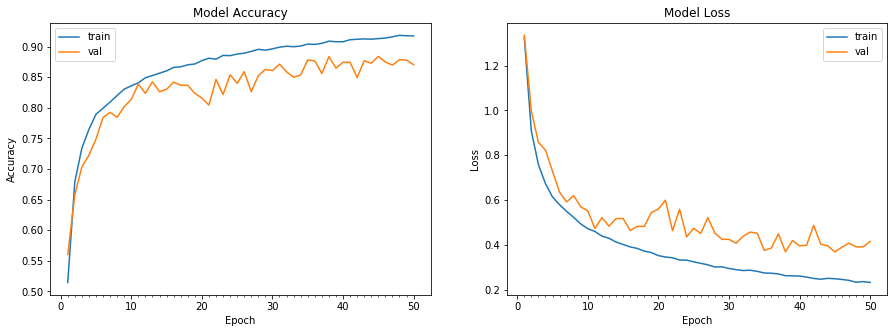

Accuracy on test data is: 87.04


In [9]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,zoom_range=0.0)
# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

**Model Prediction**: Run a prediction for the test data (model without cutout). 


In [10]:
predicted = np.argmax(model.predict(datagen.standardize(test_features)), axis = 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


**Where is CNN looking? - GradCAM:**

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.



In [0]:
def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  pooled_grads_val, layer_output_val = iterate([img])
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap

Below code is to get the ids from actual and predicted; this is done as we need the same ids for the cut-out too. 

In [12]:
idx=[index for index, elem in enumerate(np.argmax(test_labels,axis=1))  if elem == predicted[index]]
idx=np.random.choice(idx, size = 12, replace = False)
print(idx)

[4136 5612 4636 2086 6096  173 8136 9465  447 3683 3742 5609]


In the code below, we display the images (both - superimposed and the original image) after GradCAM implementation in the model. 

**Pointers:**

*   Cv2.weighted - in the way for adding two images with weights (weighted average).



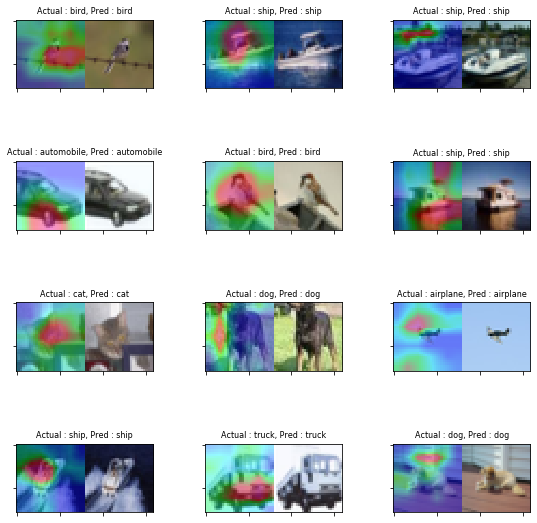

In [13]:
fig, ax = plt.subplots(4,3, figsize = (8,8))
fig.tight_layout()
a=0

for i in range(4):
 for j in range(3):
   
    #print(test_features)
    img = test_features[idx[a],::].reshape([-1,32,32,3])
    #print(img)
    unnormalized_img = test_features[idx[a],::]*255
    #print(unnormalized_img)
    heatmap = gradCAM(img, model, "conv2d_11")
    #print(heatmap)
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)/255
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    #plt.imshow(plot_img)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    true_class = class_names[np.argmax(test_labels[idx[a],].astype(int))]
    pred_class = class_names[predicted[idx[a]]]
    ax[i,j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class),fontsize=8)
    a += 1

## Data Augumentation -Cutout

**Cutout** is a simple regularization method for convolutional neural networks which consists of masking out random sections of input images during training. This technique simulates occluded examples and encourages the model to take more minor features into consideration when making decisions, rather than relying on the presence of a few major features.

The below code is a randome erasing function with the following parameters:

*   p : the probability that random erasing is performed
*   s_l, s_h : minimum / maximum proportion of erased area against       input image
*   r_1, r_2 : minimum / maximum aspect ratio of erased area
*   v_l, v_h : minimum / maximum value for erased area
*   pixel_level : pixel-level randomization for erased area.










In [0]:
import numpy as np


def get_random_eraser(p=0.6, s_l=0.05, s_h=0.4, r_1=0.3, r_2=1/0.2, v_l=0, v_h=1, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Below code we plot the some sample images from CIFAR after cutout.

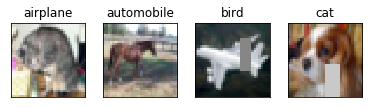

In [15]:
eraser=get_random_eraser()
#plt.imshow(eraser(train_features_1[1,::]))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(4):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.argmax(test_labels,axis=1)[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(eraser(im))
plt.show()


In [16]:
model_cutout=model=get_model()
model_cutout.summary()
model_cutout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, activation="relu", input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.6/di

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)      

**Model Fit:**

One variation from the previous run is that the addition of pre-processing function within the image generator.

**Keras Preprocessing** is the data preprocessing and data augmentation module of the Keras deep learning library. It provides utilities for working with image data, text data, and sequence data.One point to note is that we will be able to give only one function in a single preprocessing instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 16s 42ms/step - loss: 1.4631 - acc: 0.4599 - val_loss: 1.1569 - val_acc: 0.5894
Epoch 2/50
390/390 [==============================] - 14s 36ms/step - loss: 1.0545 - acc: 0.6210 - val_loss: 0.9785 - val_acc: 0.6508
Epoch 3/50
390/390 [==============================] - 14s 36ms/step - loss: 0.9175 - acc: 0.6713 - val_loss: 1.0279 - val_acc: 0.6484
Epoch 4/50
390/390 [==============================] - 14s 36ms/step - loss: 0.8359 - acc: 0.7057 - val_loss: 0.8775 - val_acc: 0.6976
Epoch 5/50
390/390 [==============================] - 14s 36ms/step - loss: 0.7752 - acc: 0.7252 - val_loss: 0.6984 - val_acc: 0.7566
Epoch 6/50
390/390 [==============================] - 14s 36ms/step - loss: 0.7384 - acc: 0.7411 - val_loss: 0.6220 - val_acc: 0.7831
Epoch 7/50
390/390 [==============================] - 14s 36ms/step - loss: 0.6987 - acc: 0.7539 - val_loss: 0.5961 - val_acc: 0.7953
Epoch 8/50
390/390 [==============================] - 14s 36ms/step - los

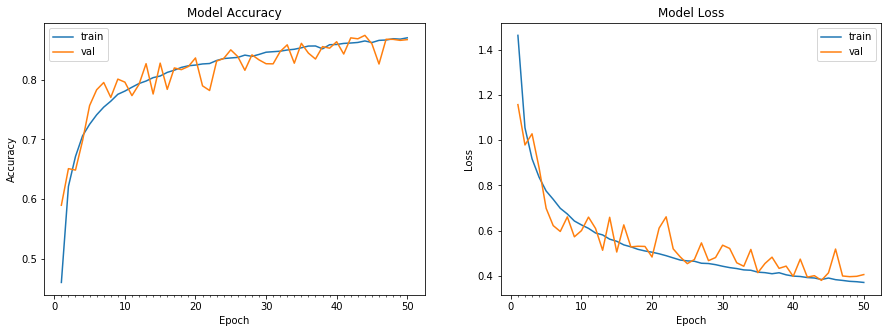

Accuracy on test data is: 86.72


In [17]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,zoom_range=0.0,preprocessing_function=get_random_eraser())
# train the model
start = time.time()
# Train the model

model_info = model_cutout.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model_cutout))

In [0]:
predicted_cutout = np.argmax(model_cutout.predict(test_features), axis = 1)

We use the same ids from the previous iteration (without cut )for the current iteration too.

In [0]:
idx=np.array([4136, 5612, 4636, 2086, 6096,  173, 8136 ,9465,  447 ,3683 ,3742, 5609])

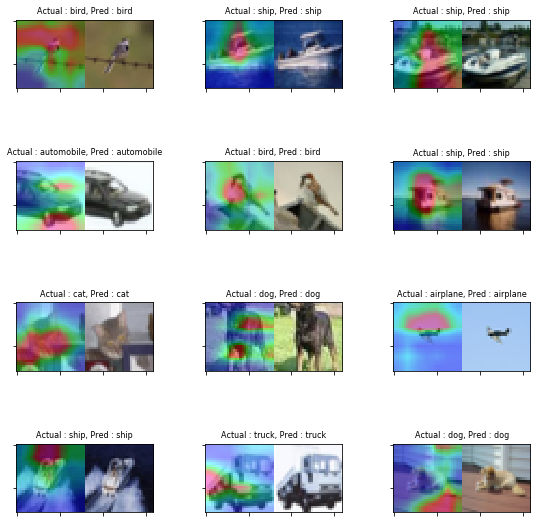

In [20]:
fig, ax = plt.subplots(4,3, figsize = (8,8))
fig.tight_layout()
a=0

for i in range(4):
 for j in range(3):
   
    #print(test_features)
    img = test_features[idx[a],::].reshape([-1,32,32,3])
    #print(img)
    unnormalized_img = test_features[idx[a],::]*255
    #print(unnormalized_img)
    heatmap = gradCAM(img, model_cutout, "conv2d_22")
    #print(heatmap)
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)/255
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    #plt.imshow(plot_img)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    true_class = class_names[np.argmax(test_labels[idx[a],].astype(int))]
    pred_class = class_names[predicted[idx[a]]]
    ax[i,j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class),fontsize=8)
    a += 1